# Laboratorium 2 - Zadanie 2

## Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Przygotowanie i wczytanie danych

In [2]:
# Przygotowanie danych
data = pd.DataFrame({
    'group': range(1, 11),
    'total': [1000, 1500, 900, 800, 1000, 800, 400, 200, 100, 400],
    'age_range': ['19-22', '23-26', '27-30', '31-34', '35-38', '39-42', '43-46', '47-50', '51-54', '55-58'],
    'work_experience': [1, 3, 5, 7, 9, 20, 20, 25, 28, 27],
    'found_job': [100, 160, 110, 130, 180, 200, 110, 60, 33, 13]
})

# Obliczenie średniego wieku i prawdopodobieństwa sukcesu
data['age_mean'] = data['age_range'].apply(lambda x: np.mean([int(i) for i in x.split('-')]))
data['success_prob'] = data['found_job'] / data['total']
data['logit'] = np.log(data['success_prob'] / (1 - data['success_prob']))

### Potencjalne nowe zmienne do modelu polinomialnego - wielomianowego

In [3]:
# Dodanie potencjalnych nowych zmiennych
data['age_squared'] = data['age_mean'] ** 2
data['exp_squared'] = data['work_experience'] ** 2
data['age_exp_interaction'] = data['age_mean'] * data['work_experience']

# Wybór zmiennych do analizy korelacji
features = ['age_mean', 'work_experience', 'age_squared', 'exp_squared', 'age_exp_interaction']
target = 'success_prob'

# Macierz korelacji
correlation_matrix = data[features + [target]].corr()

### Analiza VIF

In [4]:
X = data[features]
vif_data = pd.DataFrame()
vif_data["Variable"] = features
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(f"VIF przed skalowaniem: \n")
print(vif_data)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
vif_data_scaled = pd.DataFrame()
vif_data_scaled["Variable"] = features
vif_data_scaled["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(f"VIF po skalowaniu: \n")
print(vif_data_scaled)

VIF przed skalowaniem: 

              Variable           VIF
0             age_mean   1223.324947
1      work_experience   1006.570307
2          age_squared   5967.353403
3          exp_squared   3300.827016
4  age_exp_interaction  16767.416471
VIF po skalowaniu: 

              Variable           VIF
0             age_mean   6742.022229
1      work_experience   6551.359095
2          age_squared  21380.364988
3          exp_squared   5588.152219
4  age_exp_interaction  47116.077084


## Wizualizacja

<Figure size 1500x1200 with 0 Axes>

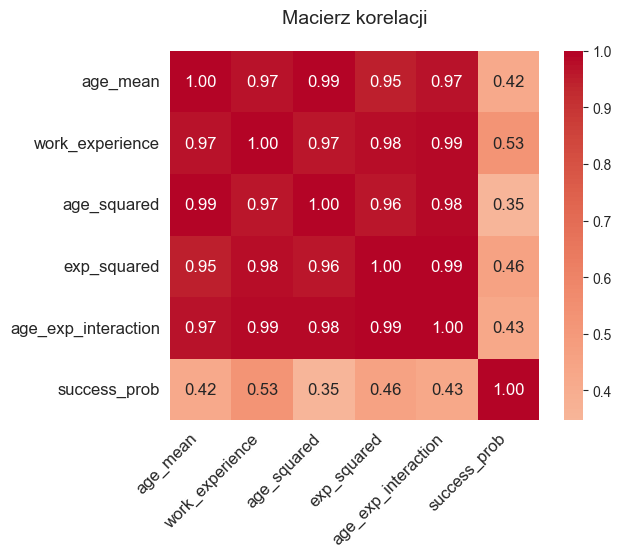

<Figure size 1200x1000 with 0 Axes>

In [5]:
plt.figure(figsize=(15, 12))
plt.tight_layout()
plt.show()
# 1. Mapa ciepła korelacji
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            annot_kws={'size': 12},
            fmt='.2f',
            square=True)
# Dostosowanie etykiet
plt.xticks(rotation=45, ha='right', fontsize=12)  # rotacja i rozmiar etykiet osi X
plt.yticks(rotation=0, fontsize=12)  # rozmiar etykiet osi Y

# Tytuł
plt.title('Macierz korelacji', pad=20, fontsize=14)  # zwiększamy rozmiar tytułu i dodajemy padding

plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.show()

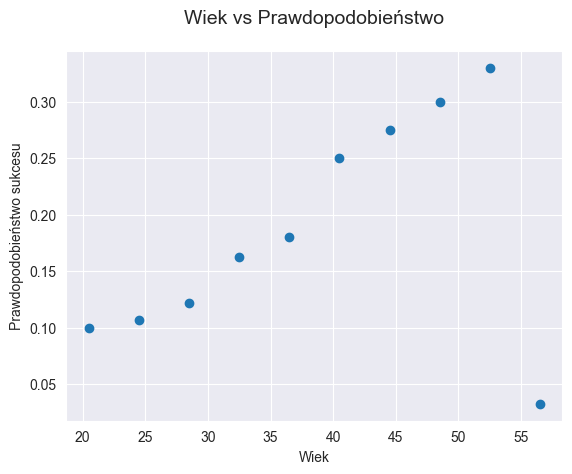

<Figure size 1200x1000 with 0 Axes>

In [6]:
# 2. Scatter plot dla wieku
plt.scatter(data['age_mean'], data['success_prob'])
plt.xlabel('Wiek')
plt.ylabel('Prawdopodobieństwo sukcesu')
plt.title('Wiek vs Prawdopodobieństwo', pad=20, fontsize=14)

plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.show()

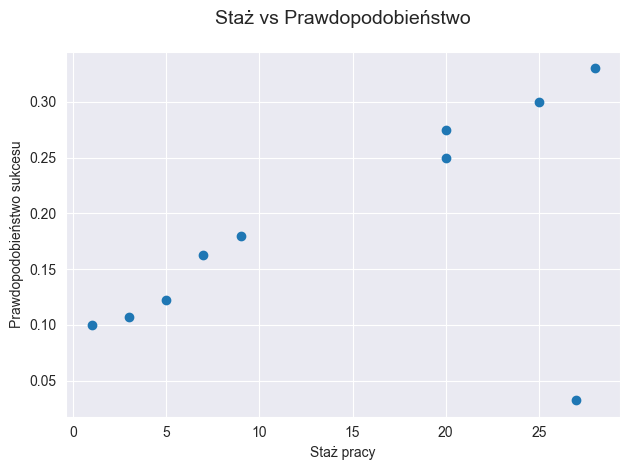

In [7]:
# 3. Scatter plot dla doświadczenia
plt.scatter(data['work_experience'], data['success_prob'])
plt.xlabel('Staż pracy')
plt.ylabel('Prawdopodobieństwo sukcesu')
plt.title('Staż vs Prawdopodobieństwo', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

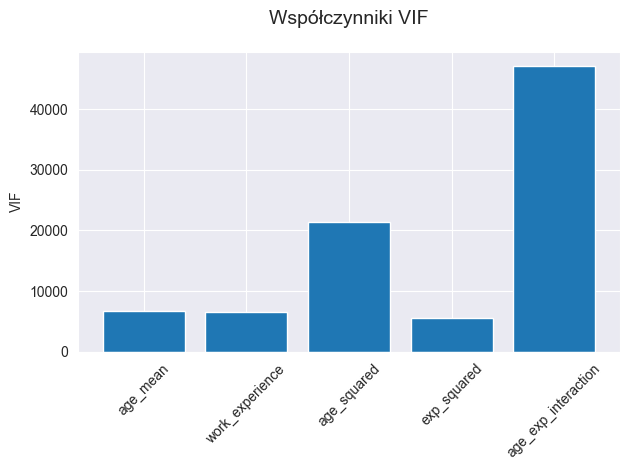

In [8]:
# 4. VIF jako wykres słupkowy dla skalowanych danych
plt.bar(vif_data['Variable'], vif_data_scaled['VIF'])
plt.xticks(rotation=45)
plt.ylabel('VIF')
plt.title('Współczynniki VIF', pad=20, fontsize=14)

plt.tight_layout()
plt.show()


# 1. Model logistyczny dla wieku i doświadczenia

In [9]:
# %matplotlib notebook
# Przygotowanie danych do modelu (X - zmienne niezależne, y - zmienna zależna)
X = data[['age_mean', 'work_experience']]
X = sm.add_constant(X)  # Dodanie stałej (odpowiada za Beta0)
y = data['success_prob']

# Dopasowanie modelu logistycznego (funkcja logit)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Wyświetlenie wyników modelu
print(result.summary())

# Obliczenie miar dopasowania
y_pred = result.predict(X)
mae = np.mean(np.abs(y - y_pred))
mse = np.mean((y - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

print("\nDodatkowe miary dopasowania:")
print(f"R² = {r2:.4f}")
print(f"MAE = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

Optimization terminated successfully.
         Current function value: 0.330785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           success_prob   No. Observations:                   10
Model:                          Logit   Df Residuals:                        7
Method:                           MLE   Df Model:                            2
Date:                Sun, 22 Dec 2024   Pseudo R-squ.:                     inf
Time:                        20:46:41   Log-Likelihood:                -3.3078
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1687      7.120      0.024      0.981     -13.786      14.124
age_mean      

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:4469: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.llf/self.llnull


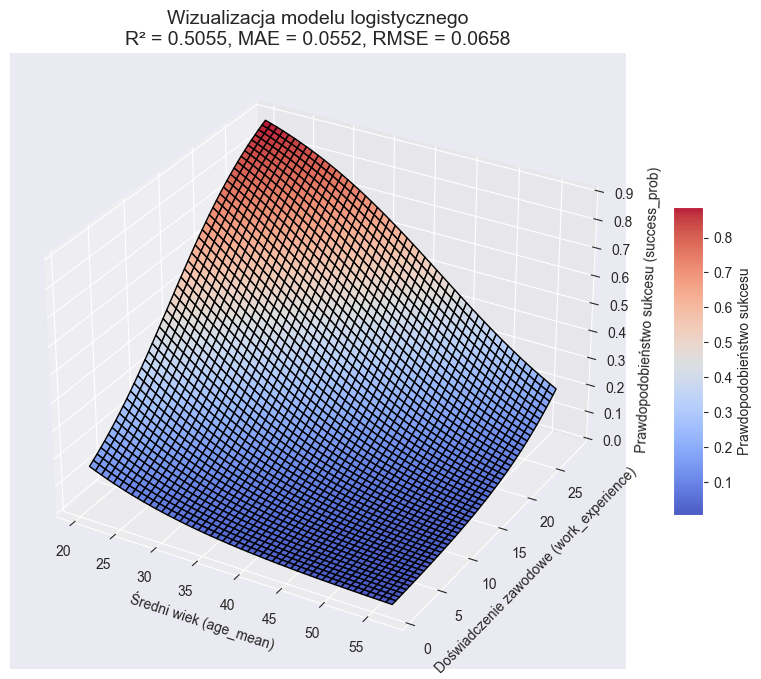

In [10]:
# Przygotowanie siatki do wizualizacji
age_range = np.linspace(data['age_mean'].min(), data['age_mean'].max(), 50)
work_exp_range = np.linspace(data['work_experience'].min(), data['work_experience'].max(), 50)
age_grid, work_exp_grid = np.meshgrid(age_range, work_exp_range)

# Obliczanie przewidywań na siatce
X_grid = sm.add_constant(np.c_[age_grid.ravel(), work_exp_grid.ravel()])
y_grid_pred = result.predict(X_grid).reshape(age_grid.shape)

# Wizualizacja 3D z poprawioną kolorystyką czarna
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Rysowanie powierzchni z lepszym kontrastem kolorów
surf = ax.plot_surface(age_grid, work_exp_grid, y_grid_pred, cmap='coolwarm', edgecolor='k', alpha=0.9)

# Dodanie paska kolorów (legendy)
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Prawdopodobieństwo sukcesu")

# Ustawienia osi i tytułu
ax.set_title("Wizualizacja modelu logistycznego\n" + 
             f"R² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}", fontsize=14)
ax.set_xlabel("Średni wiek (age_mean)", fontsize=10)
ax.set_ylabel("Doświadczenie zawodowe (work_experience)", fontsize=10)
ax.set_zlabel("Prawdopodobieństwo sukcesu (success_prob)", fontsize=10)

# Dostosowanie widoczności siatki
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.show()

In [11]:
# Wyświetlenie równania dla wcześniejszego modelu logistycznego
print("Równanie modelu logistycznego (dwie zmienne):")
print(f"logit(p) = {result.params[0]:.4f} + {result.params[1]:.4f}*wiek + {result.params[2]:.4f}*doświadczenie")
print(f"gdzie p = 1 / (1 + e^(-logit(p)))")

# Dopasowanie modelu logistycznego
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Wyświetlenie odpowiednich miar dopasowania
print("\nMiary dopasowania dla modelu logistycznego:")
print(f"Pseudo R² = {result.prsquared:.4f}")
print(f"AIC = {result.aic:.4f}")
print(f"BIC = {result.bic:.4f}")
print(f"Log-likelihood = {result.llf:.4f}")
print(f"LLR p-value = {result.llr_pvalue:.4f}")

Równanie modelu logistycznego (dwie zmienne):
logit(p) = 0.1687 + -0.0976*wiek + 0.1419*doświadczenie
gdzie p = 1 / (1 + e^(-logit(p)))
Optimization terminated successfully.
         Current function value: 0.330785
         Iterations 6

Miary dopasowania dla modelu logistycznego:
Pseudo R² = inf
AIC = 12.6157
BIC = 13.5234
Log-likelihood = -3.3078
LLR p-value = 1.0000


C:\Users\szyme\AppData\Local\Temp\ipykernel_43812\1714717151.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"logit(p) = {result.params[0]:.4f} + {result.params[1]:.4f}*wiek + {result.params[2]:.4f}*doświadczenie")
C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:4469: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.llf/self.llnull


# 2. Model logistyczny tylko dla wieku

In [12]:
### Model liniowej regresji (dwie zmienne)
# Przygotowanie danych
X = data[['age_mean', 'work_experience']]
y = data['success_prob']

# Standaryzacja zmiennych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dopasowanie modelu
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)
y_pred = lin_reg.predict(X_scaled)

Model regresji liniowej (dwie zmienne):
R² = 0.4506

Równanie regresji:
p = 0.1859 + -0.1673*wiek_stand + 0.2122*doświadczenie_stand


C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


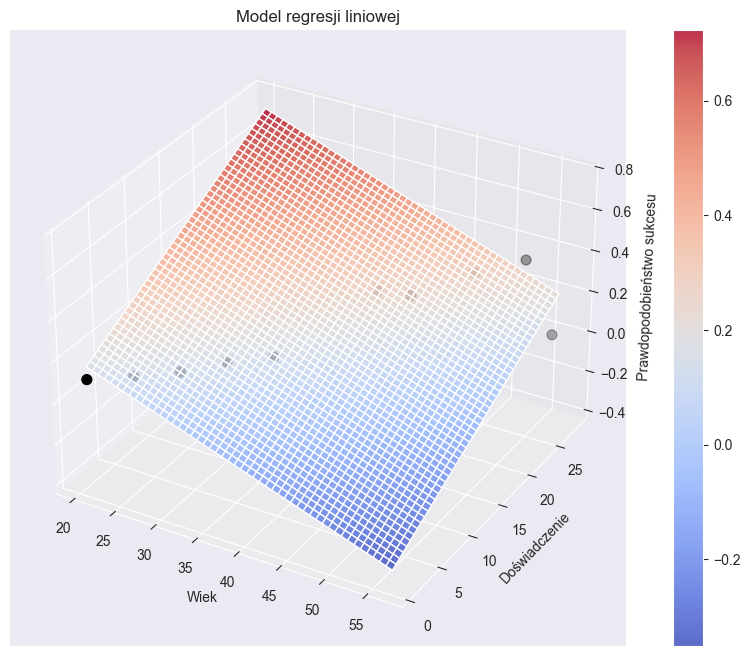

In [13]:
# Wyniki modelu
print("Model regresji liniowej (dwie zmienne):")
print(f"R² = {lin_reg.score(X_scaled, y):.4f}")
print("\nRównanie regresji:")
print(f"p = {lin_reg.intercept_:.4f} + {lin_reg.coef_[0]:.4f}*wiek_stand + {lin_reg.coef_[1]:.4f}*doświadczenie_stand")

# Wizualizacja 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Siatka do wizualizacji
age_range = np.linspace(data['age_mean'].min(), data['age_mean'].max(), 50)
exp_range = np.linspace(data['work_experience'].min(), data['work_experience'].max(), 50)
age_grid, exp_grid = np.meshgrid(age_range, exp_range)

# Przygotowanie danych do predykcji
X_grid = np.column_stack([age_grid.ravel(), exp_grid.ravel()])
X_grid_scaled = scaler.transform(X_grid)
y_grid_pred = lin_reg.predict(X_grid_scaled).reshape(age_grid.shape)

# Rysowanie powierzchni
surf = ax.plot_surface(age_grid, exp_grid, y_grid_pred, cmap='coolwarm', alpha=0.8)

# Dodanie punktów danych
ax.scatter(data['age_mean'], data['work_experience'], data['success_prob'], 
          color='black', s=50, label='Dane rzeczywiste')

ax.set_xlabel('Wiek')
ax.set_ylabel('Doświadczenie')
ax.set_zlabel('Prawdopodobieństwo sukcesu')
plt.title('Model regresji liniowej')
plt.colorbar(surf)
plt.show()

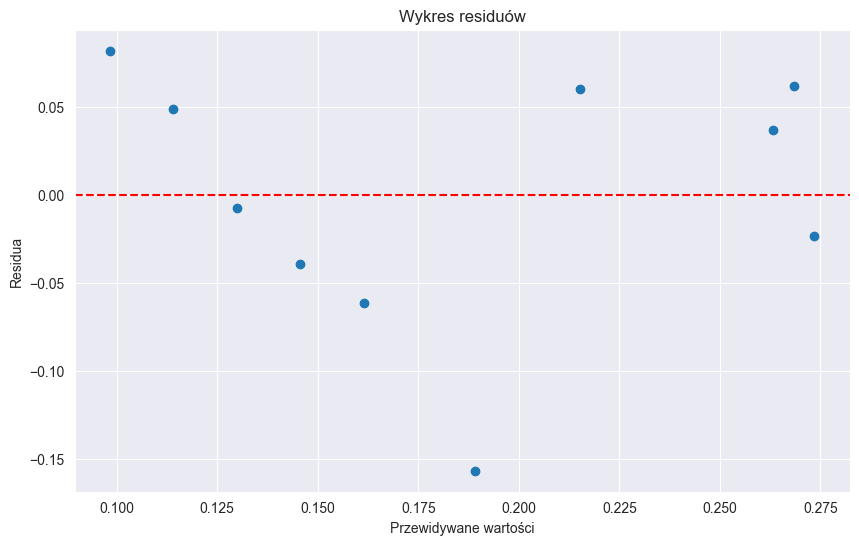


Analiza residuów:
Średnia residuów: 0.0000
Odchylenie standardowe residuów: 0.0694
Skośność residuów: -0.8941
Test Shapiro-Wilka (p-value): 0.2579


In [14]:
# Analiza residuów
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Przewidywane wartości')
plt.ylabel('Residua')
plt.title('Wykres residuów')
plt.show()

# Statystyki residuów
print("\nAnaliza residuów:")
print(f"Średnia residuów: {np.mean(residuals):.4f}")
print(f"Odchylenie standardowe residuów: {np.std(residuals):.4f}")
print(f"Skośność residuów: {stats.skew(residuals):.4f}")

# Test normalności residuów
_, p_value = stats.shapiro(residuals)
print(f"Test Shapiro-Wilka (p-value): {p_value:.4f}")

## 3. Model regresji logistycznej dla wieku 


In [15]:
# Model liniowy dla wieku z przedziałami ufności
X_age = data[['age_mean']]
y = data['success_prob']

# Standaryzacja wieku
scaler = StandardScaler()
X_age_scaled = scaler.fit_transform(X_age)

# Dopasowanie modelu
lin_reg_age = LinearRegression()
lin_reg_age.fit(X_age_scaled, y)

# Przygotowanie danych do wykresu
X_plot_orig = np.linspace(data['age_mean'].min(), data['age_mean'].max(), 100)
X_plot_scaled = (X_plot_orig - data['age_mean'].mean()) / data['age_mean'].std()
X_plot_scaled = X_plot_scaled.reshape(-1, 1)
y_pred = lin_reg_age.predict(X_plot_scaled)

# Obliczenie przedziałów ufności
n = len(X_age)
y_model = lin_reg_age.predict(X_age_scaled)
MSE = np.sum((y - y_model) ** 2) / (n - 2)
std_err = np.sqrt(MSE * (1.0/n + (X_plot_scaled - np.mean(X_age_scaled))**2 / 
                        np.sum((X_age_scaled - np.mean(X_age_scaled))**2)))
ci = 1.96 * std_err.flatten()

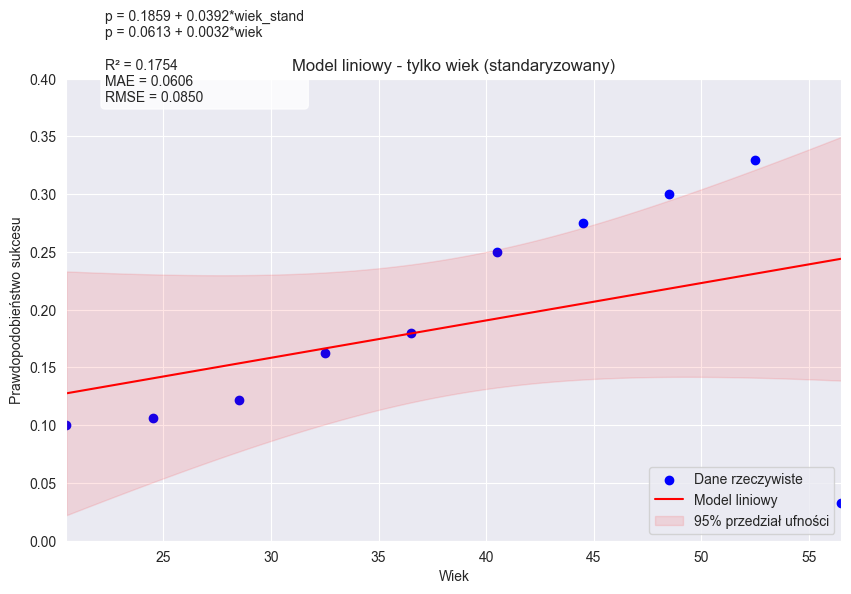


Statystyki modelu dla wieku:
R² = 0.1754
MAE = 0.0606
RMSE = 0.0850


In [16]:
# Wizualizacja
plt.figure(figsize=(10, 6))
plt.scatter(data['age_mean'], y, color='blue', label='Dane rzeczywiste')
plt.plot(X_plot_orig, y_pred, 'r-', label='Model liniowy')
plt.fill_between(X_plot_orig, y_pred - ci, y_pred + ci, color='red', alpha=0.1, label='95% przedział ufności')

# Równania i statystyki
# Równanie dla standaryzowanych danych
equation_stand = f'p = {lin_reg_age.intercept_:.4f} + {lin_reg_age.coef_[0]:.4f}*wiek_stand'

# Równanie dla oryginalnych danych
slope_orig = lin_reg_age.coef_[0] / data['age_mean'].std()
intercept_orig = lin_reg_age.intercept_ - (lin_reg_age.coef_[0] * data['age_mean'].mean()) / data['age_mean'].std()
equation_orig = f'p = {intercept_orig:.4f} + {slope_orig:.4f}*wiek'

r2 = lin_reg_age.score(X_age_scaled, y)
mae = np.mean(np.abs(y - lin_reg_age.predict(X_age_scaled)))
mse = np.mean((y - lin_reg_age.predict(X_age_scaled))**2)
rmse = np.sqrt(mse)

stats_text = f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}'
plt.text(0.05, 0.95, equation_stand + '\n' + equation_orig + '\n\n' + stats_text, 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Wiek')
plt.ylabel('Prawdopodobieństwo sukcesu')
plt.title('Model liniowy - tylko wiek (standaryzowany)')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.4)
plt.xlim(data['age_mean'].min(), data['age_mean'].max())
plt.show()

print("\nStatystyki modelu dla wieku:")
print(f"R² = {r2:.4f}")
print(f"MAE = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

## 4. Model regresji logistycznej dla wieku

In [17]:
# Model liniowy dla doświadczenia z przedziałami ufności
X_exp = data[['work_experience']]
y = data['success_prob']

# Standaryzacja doświadczenia
scaler = StandardScaler()
X_exp_scaled = scaler.fit_transform(X_exp)

# Dopasowanie modelu
lin_reg_exp = LinearRegression()
lin_reg_exp.fit(X_exp_scaled, y)

# Przygotowanie danych do wykresu
X_plot_orig = np.linspace(data['work_experience'].min(), data['work_experience'].max(), 100)
X_plot_scaled = (X_plot_orig - data['work_experience'].mean()) / data['work_experience'].std()
X_plot_scaled = X_plot_scaled.reshape(-1, 1)
y_pred = lin_reg_exp.predict(X_plot_scaled)

# Obliczenie przedziałów ufności
n = len(X_exp)
y_model = lin_reg_exp.predict(X_exp_scaled)
MSE = np.sum((y - y_model) ** 2) / (n - 2)
std_err = np.sqrt(MSE * (1.0/n + (X_plot_scaled - np.mean(X_exp_scaled))**2 / 
                        np.sum((X_exp_scaled - np.mean(X_exp_scaled))**2)))
ci = 1.96 * std_err.flatten()

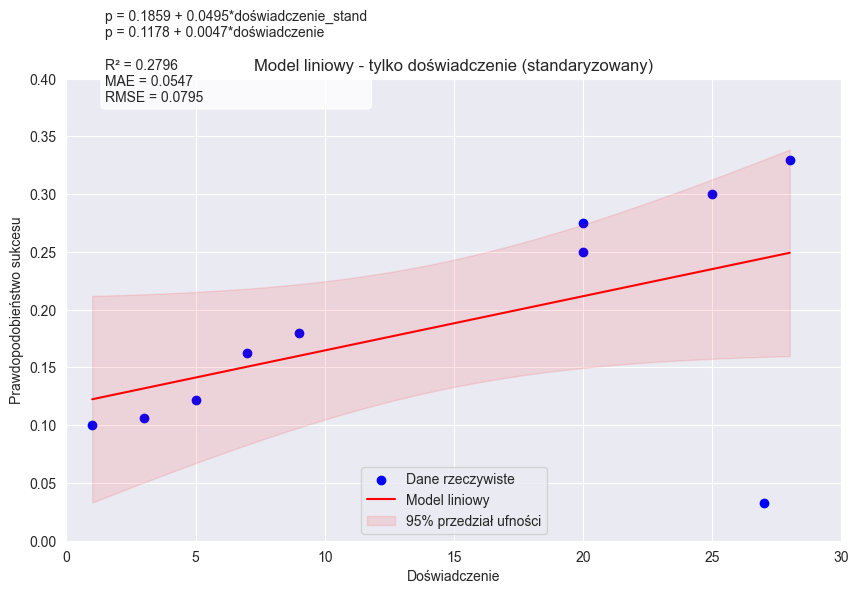


Statystyki modelu dla doświadczenia:
R² = 0.2796
MAE = 0.0547
RMSE = 0.0795


In [18]:
# Wizualizacja
plt.figure(figsize=(10, 6))
plt.scatter(data['work_experience'], y, color='blue', label='Dane rzeczywiste')
plt.plot(X_plot_orig, y_pred, 'r-', label='Model liniowy')
plt.fill_between(X_plot_orig, y_pred - ci, y_pred + ci, color='red', alpha=0.1, label='95% przedział ufności')

# Równanie dla standaryzowanych danych
equation_stand = f'p = {lin_reg_exp.intercept_:.4f} + {lin_reg_exp.coef_[0]:.4f}*doświadczenie_stand'

# Równanie dla oryginalnych danych
slope_orig = lin_reg_exp.coef_[0] / data['work_experience'].std()
intercept_orig = lin_reg_exp.intercept_ - (lin_reg_exp.coef_[0] * data['work_experience'].mean()) / data['work_experience'].std()
equation_orig = f'p = {intercept_orig:.4f} + {slope_orig:.4f}*doświadczenie'

r2 = lin_reg_exp.score(X_exp_scaled, y)
mae = np.mean(np.abs(y - lin_reg_exp.predict(X_exp_scaled)))
mse = np.mean((y - lin_reg_exp.predict(X_exp_scaled))**2)
rmse = np.sqrt(mse)

stats_text = f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}'
plt.text(0.05, 0.95, equation_stand + '\n' + equation_orig + '\n\n' + stats_text, 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Doświadczenie')
plt.ylabel('Prawdopodobieństwo sukcesu')
plt.title('Model liniowy - tylko doświadczenie (standaryzowany)')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.4)
plt.xlim(0, 30)
plt.show()

print("\nStatystyki modelu dla doświadczenia:")
print(f"R² = {r2:.4f}")
print(f"MAE = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

## 5. Model wielomianowy dla wieku i doświadczenia

In [19]:
# Przygotowanie danych
X = data[['age_mean', 'work_experience']]
y = data['success_prob']

# Standaryzacja zmiennych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Utworzenie cech wielomianowych
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Dopasowanie modelu
model = LinearRegression()
model.fit(X_poly, y)

LinearRegression()

In [20]:
# Wydruk współczynników
feature_names = ['wiek', 'doświadczenie', 'wiek²', 'wiek×doświadczenie', 'doświadczenie²']
coefficients = dict(zip(feature_names, model.coef_[1:]))

print("Równanie regresji wielomianowej:")
print(f"y = {model.intercept_:.4f}")
for name, coef in coefficients.items():
    print(f"  + {coef:.4f} × {name}")

Równanie regresji wielomianowej:
y = 0.2046
  + 0.1593 × wiek
  + -0.3718 × doświadczenie
  + 0.4540 × wiek²
  + -0.0886 × wiek×doświadczenie


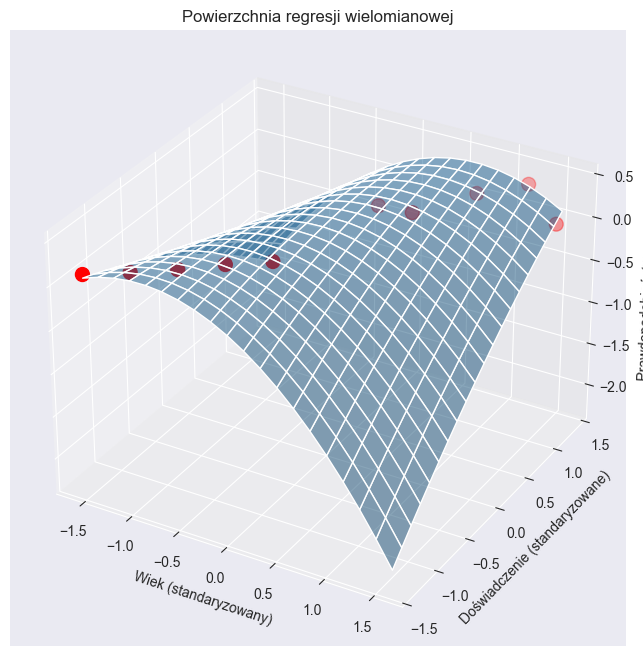

In [21]:
# Wizualizacja 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Utworzenie siatki punktów do wizualizacji
x1_grid = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 20)
x2_grid = np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 20)
xx1, xx2 = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack((xx1.ravel(), xx2.ravel()))
X_grid_poly = poly.transform(X_grid)
y_pred_grid = model.predict(X_grid_poly)

# Powierzchnia predykcji
ax.plot_surface(xx1.reshape(20, 20),
               xx2.reshape(20, 20),
               y_pred_grid.reshape(20, 20),
               alpha=0.5)

# Rzeczywiste punkty
ax.scatter(X_scaled[:, 0],
          X_scaled[:, 1],
          y,
          color='red',
          s=100)

ax.set_xlabel('Wiek (standaryzowany)')
ax.set_ylabel('Doświadczenie (standaryzowane)')
ax.set_zlabel('Prawdopodobieństwo sukcesu')
plt.title('Powierzchnia regresji wielomianowej')
plt.show()

In [22]:
# Dodanie R² i innych metryk
r2 = model.score(X_poly, y)
y_pred = model.predict(X_poly)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"\nStatystyki modelu wielomianowego:")
print(f"R² = {r2:.4f}")
print(f"MAE = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


Statystyki modelu wielomianowego:
R² = 0.8915
MAE = 0.0280
RMSE = 0.0308


In [23]:
# Tworzenie tabeli porównawczej
comparison_df = pd.DataFrame({
    'Grupa': data['group'],
    'Wiek': data['age_mean'],
    'Doświadczenie': data['work_experience'],
    'Prawdziwe_Prawdopodobieństwo': data['success_prob'].round(4),
    'Przewidywane_Prawdopodobieństwo': y_pred.round(4)
})

# Dodanie kolumny z różnicą
comparison_df['Różnica'] = (comparison_df['Prawdziwe_Prawdopodobieństwo'] - 
                           comparison_df['Przewidywane_Prawdopodobieństwo']).round(4)

# Wyświetlenie tabeli
print("\nPorównanie wartości prawdziwych i przewidywanych:")
print(comparison_df.to_string(index=False))

# Dodatkowe statystyki
print("\nDodatkowe statystyki:")
print(f"Średnia różnica: {comparison_df['Różnica'].mean():.4f}")
print(f"Maksymalna bezwzględna różnica: {comparison_df['Różnica'].abs().max():.4f}")
print(f"Odchylenie standardowe różnic: {comparison_df['Różnica'].std():.4f}")


Porównanie wartości prawdziwych i przewidywanych:
 Grupa  Wiek  Doświadczenie  Prawdziwe_Prawdopodobieństwo  Przewidywane_Prawdopodobieństwo  Różnica
     1  20.5              1                        0.1000                           0.0589   0.0411
     2  24.5              3                        0.1067                           0.1308  -0.0241
     3  28.5              5                        0.1222                           0.1688  -0.0466
     4  32.5              7                        0.1625                           0.1728  -0.0103
     5  36.5              9                        0.1800                           0.1427   0.0373
     6  40.5             20                        0.2500                           0.2772  -0.0272
     7  44.5             20                        0.2750                           0.2333   0.0417
     8  48.5             25                        0.3000                           0.3056  -0.0056
     9  52.5             28                      